# KNN Regression 

## Objectif

L'objectif de ce notebook est d'effectuer nos prédictions à l'aide d'une régression KNN.

A noter que la regression KNN est un algorithme sans mémoire. Autrement dit, il n'est pas nécessaire d'utiliser les 240 features. Comme le conseillent Krauss et al. (2017) on peut établir des prédictions à $t$ en utilisant les données à $t-m, \quad m \in \{\{1, ..., 20\} ∪ \{40, 60, ..., 240\}\}$.


<blockquote>
Krauss, C., Do, X. A., & Huck, N. (2017). Deep neural networks, gradient-boosted trees, random forests : Statistical arbitrage on the S&P 500. European Journal of Operational Research, 259(2), 689‑702. https://doi.org/10.1016/j.ejor.2016.10.031
</blockquote>

## Import des librairies

In [1]:
import os  # for path dirs and files
import tqdm  # progress bar


# to deal with data
import numpy as np
import pandas as pd

# plot the results
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

import sklearn
from sklearn.neighbors import KNeighborsRegressor

from dataset import Dataset

## Import du dataset

Dans le notebook précédent numéro 3, nous avons créé une classe dataset pour simplifier les traitement. On peut donc l'importer.

In [2]:
# import the dataset
dataset = Dataset(os.path.join('.', 'data', 'data_optimized.csv'))
print(f'\nLength of the full dataset: {len(dataset)}\n')

Import file...
Convert day to date...
Convert columns to list...

Length of the full dataset: 225208



Comme dit juste au dessus, on ne considèrera que les à $t-m, \quad m \in \{\{1, ..., 20\} ∪ \{40, 60, ..., 240\}\}$.

Par ailleurs, pour plus d'homogénéïté, nous standardiserons les données avec:
$$
\tilde{R_{t}} = \frac{R_{t} - \mu}{\sigma}
$$

$$
\mu = \frac{1}{240}\sum_{m=1}^{240} R_{0-m}
$$

$$
\sigma = \frac{1}{240}\sum_{m=1}^{240} (R_{0-m} - \mu)
$$

In [3]:
%%time
tqdm.tqdm.pandas()

print('Compute mu (mean)...')
dataset.df['mu'] = dataset.df.progress_apply(lambda row: np.mean(row['look_back_days']), axis=1)

print('Compute sigma (standard deviation)...')
dataset.df['sigma'] = dataset.df.progress_apply(lambda row: np.std(row['look_back_days']), axis=1)

print('Compute the standardized rate of return for target')
dataset.df['return'] = dataset.df.progress_apply(lambda row: (row['return'] - row['mu'])/row['sigma'], axis=1)



print('Compute the standardized rate of return in features with t-m, m in {{1,...,20} union {40,60,...,240}}...')
idx = list(range(1, 20, 1)) + list(range(40, 240 + 1, 20))
idx = 240 - np.array(idx)
dataset.df['look_back_days'] = dataset.df.progress_apply(
    lambda row: list((np.array(row['look_back_days'])[idx] - row['mu']) / row['sigma'])
    if row['look_back_days'] == row['look_back_days'] else np.nan, 
    axis=1
)

dataset.df


C:\Users\athevenot\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|                                                                  | 0/225208 [00:00<?, ?it/s]

Compute mu (mean)...


  0%|                                                                  | 0/225208 [00:00<?, ?it/s]

Compute sigma (standard deviation)...


  0%|                                                                  | 0/225208 [00:00<?, ?it/s]

Compute the standardized rate of return for target


  0%|                                                                  | 0/225208 [00:00<?, ?it/s]

Compute the standardized rate of return in features with t-m, m in {{1,...,20} union {40,60,...,240}}...


100%|██████████████████████████████████████████████████| 225208/225208 [00:19<00:00, 11640.78it/s]


Wall time: 1min 6s


,pair,day,return,set,day_count,look_back_days,mu,sigma
0,AUDCAD,2007-10-23,NaN,unpredictable,0,NaN,NaN,NaN
1,AUDCAD,2007-10-24,NaN,unpredictable,1,NaN,NaN,NaN
2,AUDCAD,2007-10-25,NaN,unpredictable,2,NaN,NaN,NaN
3,AUDCAD,2007-10-26,NaN,unpredictable,3,NaN,NaN,NaN
4,AUDCAD,2007-10-29,NaN,unpredictable,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.247127,test,2639,"[0.37560865277556804, 0.08875117406053067, 0.6...",-0.000015,0.011358
225204,ZARJPY,2020-12-28,0.412565,test,2640,"[-0.24699708244359952, 0.3757206517150503, 0.0...",-0.000017,0.011359
225205,ZARJPY,2020-12-29,-0.189763,test,2641,"[0.4079284460744835, -0.25227892373719724, 0.3...",0.000041,0.011347
225206,ZARJPY,2020-12-30,-0.605506,test,2642,"[-0.19374171048440017, 0.405266310495423, -0.2...",0.000081,0.011322


Et on peut faire le split train/validation/test

In [4]:
# split the dataset
training_dataset, validation_dataset, test_dataset = dataset.split()
print(f'Training part: {len(training_dataset)}')
print(f'Validation part: {len(validation_dataset)}')
print(f'Test part: {len(test_dataset)}')

Training part: 25647
Validation part: 23817
Test part: 159839


## Modèle Régression KNN


On peut donc se faire une petite classe pour la régression KNN sur la base de la précédente faite en notebook 3. 

In [5]:
class KNNRegressor:
    
    def __init__(self, *args, **kwargs):
        # give a name to the model
        self.name = 'knn_regressor'
        self.model = KNeighborsRegressor(*args, **kwargs)

    def __call__(self, X):
        # prediction on the feature
        X = np.array(X)        
        
        pred = self.model.predict([X])[0]
        
        return pred
    
    def fit_dataset(self, dataset):
        df = dataset.df.dropna()
        X = np.array(df['look_back_days'].tolist())
        y = np.array(df['return'].tolist())
        self.model.fit(X, y)
    
    def valid_dataset(self, dataset):
        df = dataset.df.dropna()
        X = np.array(df['look_back_days'].tolist())
        y = np.array(df['return'].tolist())
        return self.model.predict(X), y
    
    
    def _predict_row(self, row):
        
        # predict the row only if it is not Nan of course
        if row.look_back_days != row.look_back_days:
            return np.nan
        else:
            return self.__call__(row.look_back_days)
        
    def predict_all_dataset(self, dataset, progress_bar=True):
        
        # get the primary keys (pair and day) and info (return and set) from the dataset
        predictions_df = pd.DataFrame(dataset.df[['pair', 'day', 'return', 'set']])
        
        # run the prediction all along the dataset and return it as a dataframe of predictions
        if progress_bar:
            tqdm.tqdm.pandas()
            predictions_df[self.name] = dataset.df.progress_apply(self._predict_row, axis=1)
        else:
            predictions_df[self.name] = dataset.df.apply(self._predict_row, axis=1)        
            
        return predictions_df
            
model = KNNRegressor()

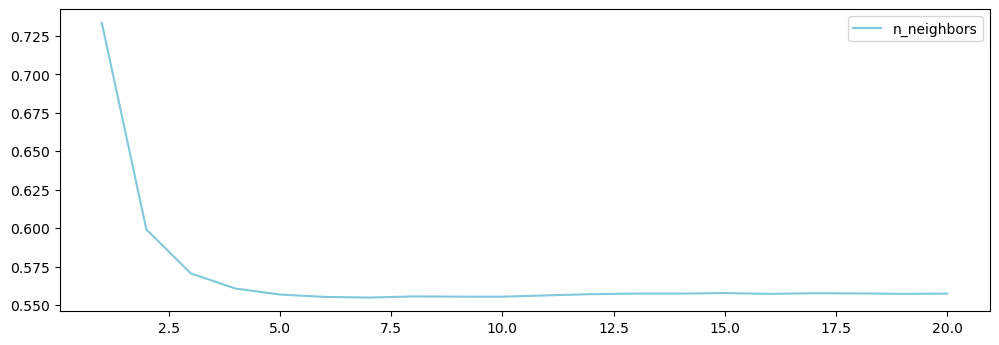

,n_neighbors,rmse
6,7,0.554863
5,6,0.555289
9,10,0.555408
8,9,0.555462
7,8,0.555593
10,11,0.556270
4,5,0.556826
11,12,0.557061
15,16,0.557252
18,19,0.557260


In [6]:
RE_RUN = False

results_df = pd.DataFrame()
param_grid = {'n_neighbors': range(1, 20 + 1)}


if RE_RUN:
    for param in sklearn.model_selection.ParameterGrid(param_grid):

        model = KNNRegressor(**param)

        model.fit_dataset(training_dataset)
        pred, y = model.valid_dataset(validation_dataset)
        rmse = (((pred - y)**2)**1/2).mean()

        print(f'Parameters: {param}\n\tRMSE: {rmse}\n')
        param['rmse'] = rmse
        results_df = results_df.append(param, ignore_index=True)
else:
    # these are save results copy paste from the run
    save_results = [
        0.73337539, 0.59911447, 0.57057331, 0.56073838, 0.55682648,
        0.55528858, 0.55486266, 0.55559313, 0.5554618 , 0.55540805,
        0.55627032, 0.55706075, 0.55743258, 0.55744388, 0.55778134,
        0.55725239, 0.55766749, 0.55755049, 0.55726029, 0.55744672
    ]
    results_df = pd.DataFrame(sklearn.model_selection.ParameterGrid(param_grid))
    results_df['rmse'] = save_results

for param_name in param_grid.keys():
    # evaluation of the parameters thanks to the groupby --> mean 
    param_df= results_df.groupby(param_name).mean().reset_index()
    # set the kind of plot according to the type of the parameter
    kind = 'line' if np.array(param_df[param_name]).dtype == 'float64' else 'bar'
    # and plot
    param_df.plot(param_name, 'rmse', color='#0593ba', alpha=0.5, label=param_name, kind=kind)
    plt.legend()
    plt.show()
results_df.sort_values('rmse')

In [7]:
model = KNNRegressor(n_neighbors=7)
model.fit_dataset(training_dataset)

## Prédiction sur tout le dataset et analyse

Maintenant que notre modèle est entrainé, on peut faire les prédictions sur tout le dataset. 

In [8]:
predictions_df = model.predict_all_dataset(dataset)
predictions_df

C:\Users\athevenot\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████████████████████████████████████████████| 225208/225208 [19:18<00:00, 194.42it/s]


,pair,day,return,set,knn_regressor
0,AUDCAD,2007-10-23,NaN,unpredictable,NaN
1,AUDCAD,2007-10-24,NaN,unpredictable,NaN
2,AUDCAD,2007-10-25,NaN,unpredictable,NaN
3,AUDCAD,2007-10-26,NaN,unpredictable,NaN
4,AUDCAD,2007-10-29,NaN,unpredictable,NaN
...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.247127,test,0.131247
225204,ZARJPY,2020-12-28,0.412565,test,0.305749
225205,ZARJPY,2020-12-29,-0.189763,test,0.430002
225206,ZARJPY,2020-12-30,-0.605506,test,-0.121440


A noter que l'on a transformé nos données en les normalisant.
Il faut donc pouvoir dénormaliser nos prédiction $\hat{\tilde{R_{0}}}$ tel que:

$$
\hat{R_{0}} = \hat{\tilde{R_{0}}} * \sigma + \mu
$$

Donc nous avons besoin de refaire la jointure avec le dataset pour nos prédictions

In [9]:

predictions_df = predictions_df.merge(dataset.df[['pair', 'day', 'mu', 'sigma']], how='inner', on=['pair', 'day'])
predictions_df

,pair,day,return,set,knn_regressor,mu,sigma
0,AUDCAD,2007-10-23,NaN,unpredictable,NaN,NaN,NaN
1,AUDCAD,2007-10-24,NaN,unpredictable,NaN,NaN,NaN
2,AUDCAD,2007-10-25,NaN,unpredictable,NaN,NaN,NaN
3,AUDCAD,2007-10-26,NaN,unpredictable,NaN,NaN,NaN
4,AUDCAD,2007-10-29,NaN,unpredictable,NaN,NaN,NaN
...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.247127,test,0.131247,-0.000015,0.011358
225204,ZARJPY,2020-12-28,0.412565,test,0.305749,-0.000017,0.011359
225205,ZARJPY,2020-12-29,-0.189763,test,0.430002,0.000041,0.011347
225206,ZARJPY,2020-12-30,-0.605506,test,-0.121440,0.000081,0.011322


In [10]:

print('Compute the un-standardized rate of return for target')
predictions_df['return'] = predictions_df.progress_apply(lambda row: row['return'] * row['sigma'] + row['mu'], axis=1)
print('Compute the un-standardized rate of return for prediction')
predictions_df[model.name] = predictions_df.progress_apply(lambda row: row[model.name] * row['sigma'] + row['mu'], axis=1)
predictions_df


  0%|                                                                  | 0/225208 [00:00<?, ?it/s]

Compute the un-standardized rate of return for target


  0%|                                                                  | 0/225208 [00:00<?, ?it/s]

Compute the un-standardized rate of return for prediction


100%|██████████████████████████████████████████████████| 225208/225208 [00:07<00:00, 30713.28it/s]


,pair,day,return,set,knn_regressor,mu,sigma
0,AUDCAD,2007-10-23,NaN,unpredictable,NaN,NaN,NaN
1,AUDCAD,2007-10-24,NaN,unpredictable,NaN,NaN,NaN
2,AUDCAD,2007-10-25,NaN,unpredictable,NaN,NaN,NaN
3,AUDCAD,2007-10-26,NaN,unpredictable,NaN,NaN,NaN
4,AUDCAD,2007-10-29,NaN,unpredictable,NaN,NaN,NaN
...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,0.001476,-0.000015,0.011358
225204,ZARJPY,2020-12-28,0.004670,test,0.003456,-0.000017,0.011359
225205,ZARJPY,2020-12-29,-0.002113,test,0.004920,0.000041,0.011347
225206,ZARJPY,2020-12-30,-0.006775,test,-0.001294,0.000081,0.011322


Maintenant on peut afficher la distribution des prédictions en fonction des ground truth 

In [11]:
def plot_scatter_and_hist(predictions_df, filter_set=None, color='#0593ba', label='', axes=None):

    # definition for set(s) to plot    
    if filter_set is not None: # no filter
        if isinstance(filter_set, str): # convert to list if it is string to be homogeneous
            filter_set = [filter_set]
        # make the filter on the set(s)
        predictions_df = predictions_df[predictions_df['set'].isin(filter_set)]
    # drop Nan values 
    predictions_df = predictions_df.dropna()

    # definitions for the axes
    if axes is None:
        # set the axes dimensions
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        spacing = 0.005
        
        # compute their rectangle
        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom + height + spacing, width, 0.2]
        rect_histy = [left + width + spacing, bottom, 0.2, height]
        ax_scatter = plt.axes(rect_scatter)
        
        # create the axes
        ax_scatter.tick_params(direction='in', top=True, right=True)
        ax_histx = plt.axes(rect_histx)
        ax_histy = plt.axes(rect_histy)
        ax_histx.tick_params(direction='in', labelbottom=False)
        ax_histy.tick_params(direction='in', labelleft=False)
        
        ax_scatter.set_xlabel('True')
        ax_scatter.set_ylabel('Prediction')
        
        # add the zero's lines to be more comprehensive
        ax_scatter.axvline(x=0, color='#000000', alpha=0.3)
        ax_scatter.axhline(y=0, color='#000000', alpha=0.3)
        ax_histx.axvline(  x=0, color='#000000', alpha=0.3)
        ax_histy.axhline(  y=0, color='#000000', alpha=0.3)
    else:
        ax_scatter, ax_histx, ax_histy = axes
        

    # the scatter plot
    ax_scatter.scatter(predictions_df['return'], predictions_df[model.name], color=color, alpha=0.01)
    
    # the histograms
    bins = 100
    ax_histx.hist(predictions_df['return'], bins=bins, density=True, color=color, alpha=0.3, label=label)
    ax_histy.hist(predictions_df[model.name], bins=bins, density=True, color=color, alpha=0.3, orientation='horizontal')
    
    # set the limit on histograms to have its axis aligned to the scatter plot
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    return ax_scatter, ax_histx, ax_histy
    

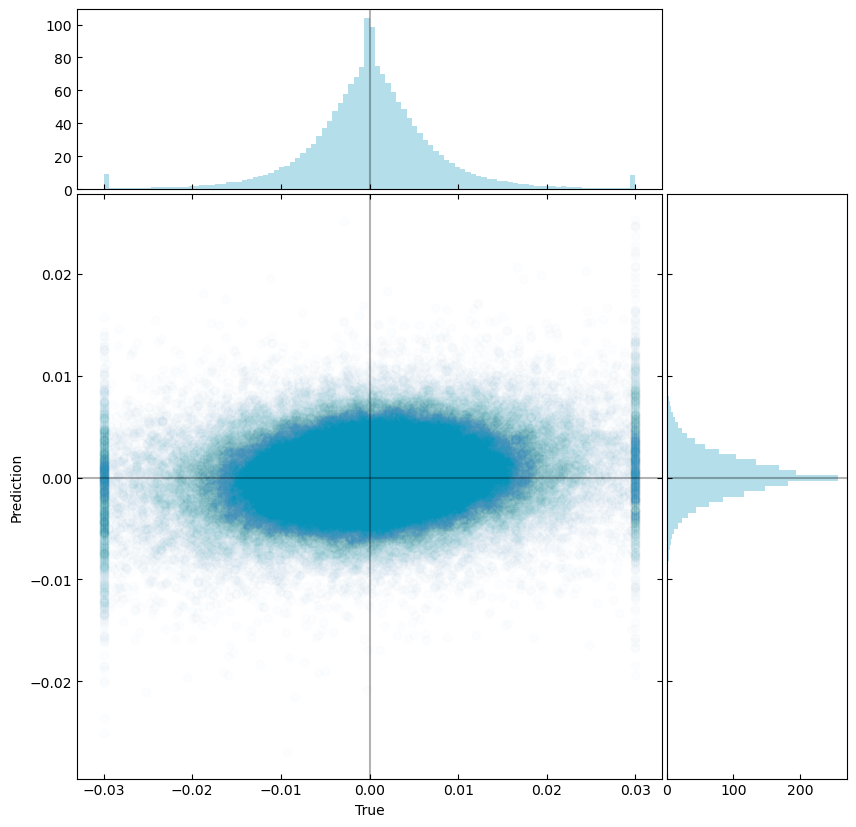

In [12]:
plt.rcParams['figure.figsize'] = [9, 9]    
plot_scatter_and_hist(predictions_df)
plt.rcParams['figure.figsize'] = [12, 4]

pass

Il est encore pertinent de visualiser si la distribution des erreurs est normale ou non. Du moins, vérifier si elle est centrée en zéro et interpréter sont applatissement.

A noter que l'erreur est donnée par la formule suivante:

$error = \hat{R_{0}} - R_{0}$

C:\Users\athevenot\AppData\Roaming\Python\Python38\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\athevenot\AppData\Roaming\Python\Python38\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


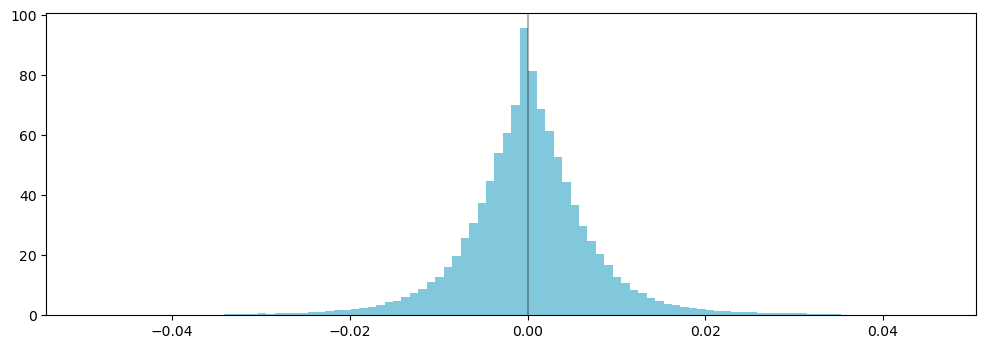

In [13]:
error = predictions_df[model.name] - predictions_df['return']
plt.hist(error, bins=100, density=True, color='#0593ba', alpha=0.5)
plt.axvline(x=0, color='#000000', alpha=0.3)

pass

Et enfin, on peut s'attarder sur les métriques statistiques globales et par split de dataset

In [14]:
pd.options.display.float_format = '{:.8f}'.format
error_table = error.agg(['mean', 'std', 'skew', 'kurt']).reset_index()
error_table

,index,0
0,mean,0.00007317
1,std,0.00750657
2,skew,0.02751634
3,kurt,3.47061103


In [15]:
set_df = predictions_df[['set']]
set_df['error'] = error
pd.options.display.float_format = "{0:.8f}".format
error_table = set_df.groupby(['set']).agg({'error':['mean', 'std', pd.Series.skew, pd.Series.kurt]}).reset_index()
error_table

<ipython-input-15-f608eb69fba6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_df['error'] = error


set      error                                  
                       mean        std        skew       kurt
0           test 0.00007459 0.00803088  0.02532814 3.07512881
1       training 0.00006347 0.00517284  0.09006352 2.37505923
2  unpredictable        nan        nan         nan        nan
3     validation 0.00007406 0.00579170 -0.00144259 3.06038070

In [16]:
pd.options.display.float_format = None

## Sauvegarde des données

Ne reste plus qu'à sauvegarder nos données. 

Pour cela, on reprend les fichier `results.csv` établit lors du notebook précédent et on y joint les nouvelles prédiction du modèle de ce notebook

In [17]:
df = pd.read_csv(os.path.join('.', 'data', 'results.csv'))  # read file
df['day'] = pd.to_datetime(df['day'])                       # convert the str days to dates

# can be useufl when reloaded
if model.name in df.columns:
    df = df.drop(columns=model.name)

df

,pair,day,return,set,naive,linear_regression,knn_regressor_x,knn_regressor_y
0,AUDCAD,2007-10-23,0.007541,unpredictable,NaN,NaN,NaN,NaN
1,AUDCAD,2007-10-24,0.003915,unpredictable,NaN,NaN,NaN,NaN
2,AUDCAD,2007-10-25,0.002523,unpredictable,NaN,NaN,NaN,NaN
3,AUDCAD,2007-10-26,0.005835,unpredictable,NaN,NaN,NaN,NaN
4,AUDCAD,2007-10-29,0.007962,unpredictable,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,0.004251,0.000222,0.001476,0.001476
225204,ZARJPY,2020-12-28,0.004670,test,-0.002822,-0.000062,0.003456,0.003456
225205,ZARJPY,2020-12-29,-0.002113,test,0.004670,-0.000604,0.004920,0.004920
225206,ZARJPY,2020-12-30,-0.006775,test,-0.002113,0.000037,-0.001294,-0.001294


In [18]:
df = df.merge(predictions_df[['pair', 'day', model.name]], how='inner', on=['pair', 'day'])
df

,pair,day,return,set,naive,linear_regression,knn_regressor_x,knn_regressor_y,knn_regressor
0,AUDCAD,2007-10-23,0.007541,unpredictable,NaN,NaN,NaN,NaN,NaN
1,AUDCAD,2007-10-24,0.003915,unpredictable,NaN,NaN,NaN,NaN,NaN
2,AUDCAD,2007-10-25,0.002523,unpredictable,NaN,NaN,NaN,NaN,NaN
3,AUDCAD,2007-10-26,0.005835,unpredictable,NaN,NaN,NaN,NaN,NaN
4,AUDCAD,2007-10-29,0.007962,unpredictable,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,0.004251,0.000222,0.001476,0.001476,0.001476
225204,ZARJPY,2020-12-28,0.004670,test,-0.002822,-0.000062,0.003456,0.003456,0.003456
225205,ZARJPY,2020-12-29,-0.002113,test,0.004670,-0.000604,0.004920,0.004920,0.004920
225206,ZARJPY,2020-12-30,-0.006775,test,-0.002113,0.000037,-0.001294,-0.001294,-0.001294


Avant de sauvegarder, on peut quand même s'amuser à comparer les prédictions desmodèles à cette étape

In [19]:
pd.options.display.float_format = "{0:.6f}".format
df.drop(columns=['pair', 'day', 'return']).groupby('set').agg(['mean', 'std', pd.Series.skew, pd.Series.kurt]).reset_index().transpose()

0         1              2           3
set                         test  training  unpredictable  validation
naive             mean  0.000118  0.000035            NaN   -0.000012
                  std   0.007911  0.006061            NaN    0.006012
                  skew -0.033118 -0.085883            NaN   -0.076113
                  kurt  2.974460  2.633147            NaN    3.822572
linear_regression mean  0.000087  0.000012            NaN   -0.000025
                  std   0.000599  0.000486            NaN    0.000464
                  skew  0.025856 -0.088439            NaN   -0.416042
                  kurt  4.617782  1.490406            NaN    2.115215
knn_regressor_x   mean  0.000191  0.000099            NaN    0.000062
                  std   0.002669  0.002271            NaN    0.002101
                  skew  0.048623  0.049620            NaN   -0.087633
                  kurt  3.730894  4.064949            NaN    5.710044
knn_regressor_y   mean  0.000191  0.000099            NaN    0.000062
                  std   0.002669  0.002271            NaN    0.002101
                  skew  0.048623  0.049620            NaN   -0.087633
                  kurt  3.730894  4.064949            NaN    5.710044
knn_regressor     mean  0.000191  0.000099            NaN    0.000062
                  std   0.002669  0.002271            NaN    0.002101
                  skew  0.048623  0.049620            NaN   -0.087633
                  kurt  3.730894  4.064949            NaN    5.710044

In [20]:
df.to_csv(os.path.join('.', 'data', 'results.csv'), index=False)

## Sanity check

In [ ]:
df = pd.read_csv(os.path.join('.', 'data', 'results.csv'))  # read file
df['day'] = pd.to_datetime(df['day'])                       # convert the str days to dates
df